# Algorythmes Détecteur de faux billets 

## 1 Préparation du fichier
### 1.1 Importation des librairies

In [1]:
#Importation de la librairie Pandas
import pandas as pd
#Importation de la librairie matplotlib
import matplotlib.pyplot as plt
#Importation de la librairie Numpy
import numpy as np
#Importation de la librairie seaborn
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import statsmodels.api as sm
import joblib

### 1.2 Importation du fichier

In [2]:
#Importation du fichier billets
df_billets = pd.read_csv('df_billets_modifie.csv')

## 1.3 Visualisation des données

In [3]:
df_billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


## 2. Analyse en Composantes Principales

### 2.1 Normalisation des données

Séparation des données X = Matrice des données Names = Variable avec les qualitatifs features = Variable pour les colonnes

In [4]:
#Matrice des données
X = df_billets.drop(columns=["is_genuine"])

In [5]:
#Verification np.array
type(X)

pandas.core.frame.DataFrame

In [6]:
#Vérification Matrice
X.shape

(1500, 6)

In [7]:
#Enregistrement is_genuine dans une variable
names = df_billets["is_genuine"]
names

0        True
1        True
2        True
3        True
4        True
        ...  
1495    False
1496    False
1497    False
1498    False
1499    False
Name: is_genuine, Length: 1500, dtype: bool

In [8]:
# Variable Features pour nos variables
features = df_billets.columns.drop(["is_genuine"])
features

Index(['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'length'],
      dtype='object')

### 2.2 Création ACP

In [9]:
#Scaler les données
scaler = StandardScaler()

In [10]:
scaler.fit(X)

StandardScaler()

In [11]:
#On transforme
X_scaled = scaler.transform(X)
X_scaled[:5]

array([[-0.48653957,  2.77412327,  3.16324041,  0.05606053, -1.128325  ,
         0.17365114],
       [-1.63372936, -2.23653528, -0.79966777, -1.08027474, -0.69679916,
         0.47166629],
       [ 2.3978233 ,  1.50475644, -1.29119126, -0.12575311, -0.91256208,
         0.55190114],
       [-1.96149786, -0.39929381,  0.06049835, -1.3075418 , -0.61049399,
         0.95307539],
       [-0.74875438,  0.83666863, -1.41407214, -0.67119404,  1.41767746,
        -0.15875038]])

In [12]:
#Vérification moyenne et ecart type
idx = ["mean", "std"]
pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5
mean,-0.0,0.0,-0.0,0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0


### 2.3 Recherche du nombre de CP

In [13]:
pca = PCA(n_components=0.90)  # On veut 90% de variance expliquée
X_pca = pca.fit_transform(X_scaled)


print(f"Nombre de composantes retenues : {pca.n_components_}")

Nombre de composantes retenues : 5


In [14]:
# Nous allons travailléer sur nos 5 composantes
n_components = 5

In [15]:
#On instancie notre ACP
pca = PCA(n_components=n_components)

In [16]:
#On l'entraine sur les données scalées
pca.fit(X_scaled)

PCA(n_components=5)

In [17]:
#variance captée par chaque nouvelle composante
pca.explained_variance_ratio_

array([0.43207173, 0.16958031, 0.13017891, 0.11824016, 0.09668004])

In [18]:
#Enregistrement dans une variable
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([43.21, 16.96, 13.02, 11.82,  9.67])

In [19]:
#Calcul somme cumulée.
scree_cum = scree.cumsum().round()
scree_cum

array([43., 60., 73., 85., 95.])

In [20]:
#variable avec la liste de nos composantes
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4, 5]

In [21]:
#Creation d 'un tableau pour visualisé la variance
df_scree = pd.DataFrame({
    'Composante': [f'PC{i+1}' for i in range(len(scree))],
    'Variance expliquée': np.round(scree, 4),
    'Variance cumulée': np.round(scree_cum, 4)
})

df_scree

,Composante,Variance expliquée,Variance cumulée
0,PC1,43.21,43.0
1,PC2,16.96,60.0
2,PC3,13.02,73.0
3,PC4,11.82,85.0
4,PC5,9.67,95.0


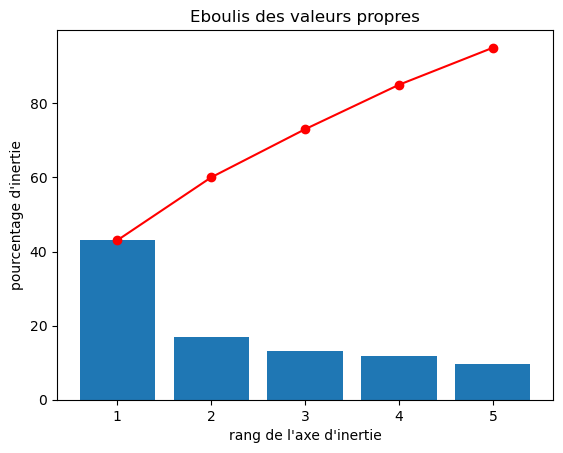

In [22]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [23]:
#Calcul des composantes
pcs = pca.components_
pcs

array([[ 0.08500406, -0.33142116, -0.3937944 , -0.50661445, -0.43920041,
         0.5275463 ],
       [ 0.94123818,  0.30732992,  0.10877454, -0.07357978, -0.00408976,
         0.04854279],
       [-0.28667247,  0.88464437, -0.16727964, -0.10553161, -0.27142929,
         0.14976641],
       [-0.10300314, -0.04666439,  0.86620964, -0.09023524, -0.44413886,
         0.17745965],
       [-0.11825788,  0.10442072,  0.23403786, -0.57127618,  0.70935985,
         0.30131345]])

In [24]:
#Version panda
pcs = pd.DataFrame(pcs)
pcs

,0,1,2,3,4,5
0,0.085004,-0.331421,-0.393794,-0.506614,-0.439200,0.527546
1,0.941238,0.307330,0.108775,-0.073580,-0.004090,0.048543
2,-0.286672,0.884644,-0.167280,-0.105532,-0.271429,0.149766
3,-0.103003,-0.046664,0.866210,-0.090235,-0.444139,0.177460
4,-0.118258,0.104421,0.234038,-0.571276,0.709360,0.301313


In [25]:
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

,diagonal,height_left,height_right,margin_low,margin_up,length
F1,0.09,-0.33,-0.39,-0.51,-0.44,0.53
F2,0.94,0.31,0.11,-0.07,-0.00,0.05
F3,-0.29,0.88,-0.17,-0.11,-0.27,0.15
F4,-0.10,-0.05,0.87,-0.09,-0.44,0.18
F5,-0.12,0.10,0.23,-0.57,0.71,0.30


<Axes: >

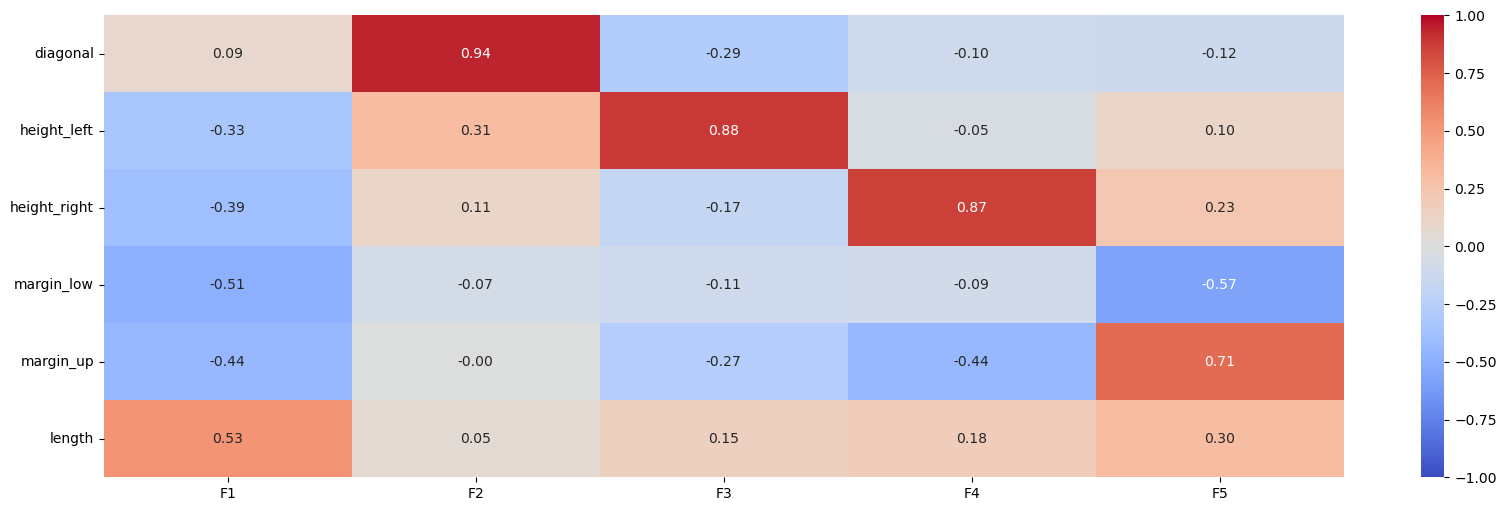

In [26]:
# Visualisation des variables dans chaque composante principale a l aide d'un headmap
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

## 2.4 Cercle de correlation

In [27]:
x, y = 0,1

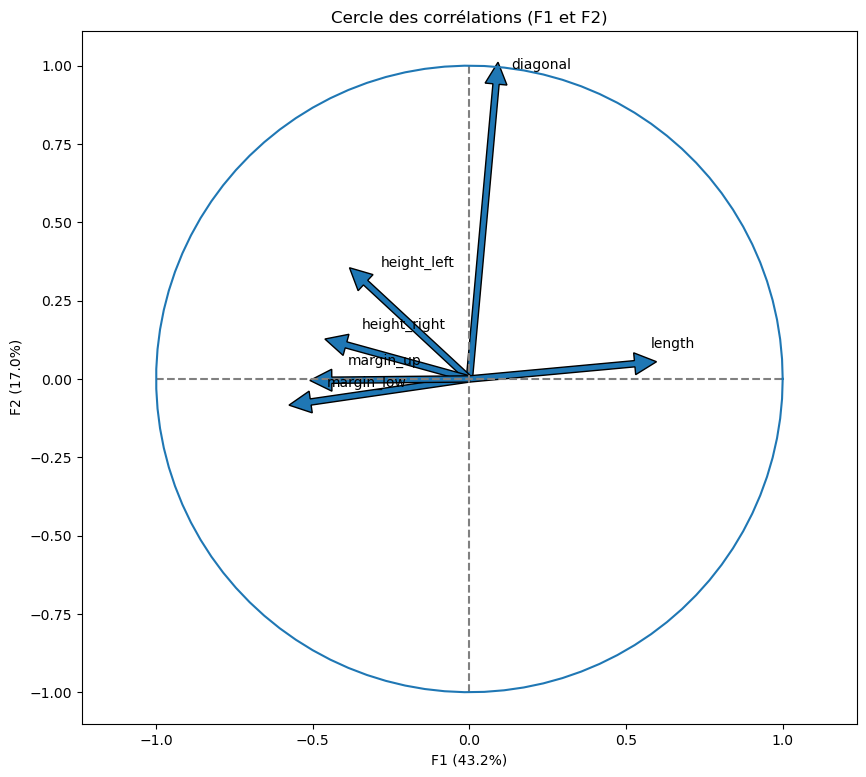

In [28]:
fig, ax = plt.subplots(figsize=(10, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              )

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             features[i])
    
# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.show(block=False)

In [29]:
#calculons les coordonnées de nos individus
X_proj = pca.transform(X_scaled)
X_proj[:5]

array([[-1.64765861,  0.74762064,  2.39079573,  3.18758209,  0.30744002],
       [ 2.01940926, -2.20683402, -1.00265038,  0.07062204,  0.0374815 ],
       [ 0.96923985,  2.61870665,  1.20339765, -0.92105236, -0.83782129],
       [ 1.3751154 , -1.81740058,  0.64538589,  0.83134036,  0.80550893],
       [-0.15043926, -0.56555579,  0.85360446, -1.78405357,  1.18621224]])

In [30]:
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        # j'ai copié collé la fonction sans la lire
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

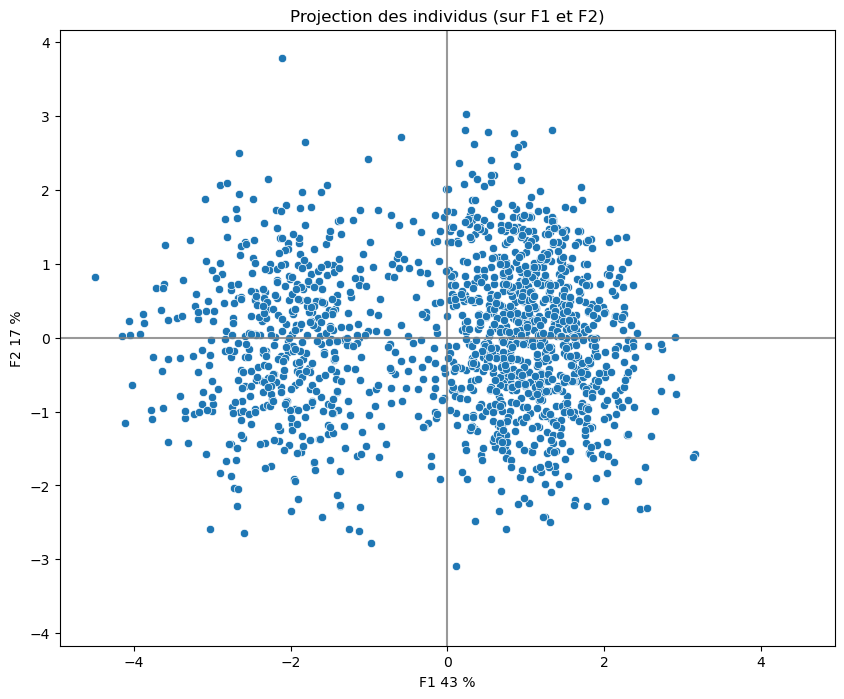

In [31]:
# Visualisation des pays sur F1 et F2
x_y = [0, 1]
display_factorial_planes(X_proj, x_y, pca=pca,)

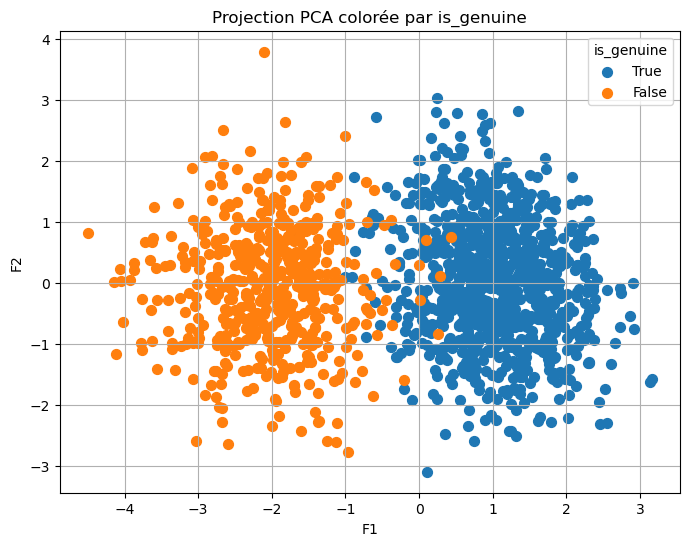

In [32]:
plt.figure(figsize=(8, 6))

for label in names.unique():
    idx = names == label
    plt.scatter(X_proj[idx, 0], X_proj[idx, 1], label=label, s=50)

plt.xlabel("F1")
plt.ylabel("F2")
plt.title("Projection PCA colorée par is_genuine")
plt.legend(title="is_genuine")
plt.grid(True)
plt.show()

## 3. K-means

Recherche du nombre de cluster avec la methode du coude. On defini d'abord une liste vide pour stocker nos inerties

In [33]:
intertia = []

In [34]:
kmeans = KMeans(n_clusters=2)

In [35]:
kmeans.fit(X)

KMeans(n_clusters=2)

In [36]:
kmeans.inertia_

969.6798636440444

In [37]:
k_list = range(1, 10)
list(k_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [38]:
for i in k_list :
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(X) 
  intertia.append(kmeans.inertia_)

In [39]:
intertia

[2308.7018654049953,
 969.6618834275653,
 876.9059265907017,
 772.4501462937102,
 726.7757378582482,
 673.6954912539977,
 629.2274276169882,
 613.0143046158497,
 570.7993940949261]

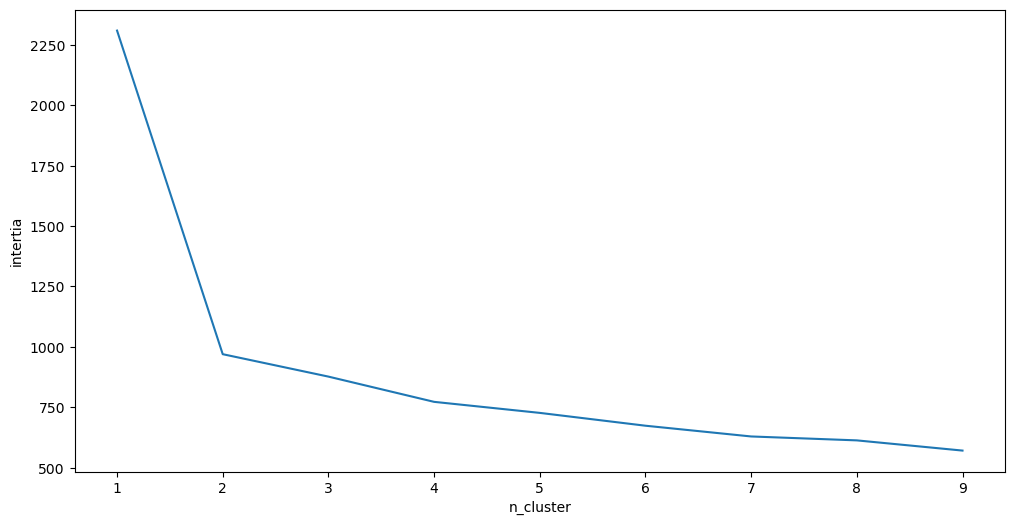

In [40]:
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("intertia")
ax.set_xlabel("n_cluster")
ax = plt.plot(k_list, intertia)

In [41]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

KMeans(n_clusters=2)

In [42]:
kmeans.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [43]:
dd = {i:j for i,j in enumerate(list("ab"))}
dd

{0: 'a', 1: 'b'}

In [44]:
labels = [dd[i] for i in kmeans.labels_]
labels[:10]

['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']

In [45]:
X["cluster"] = labels
X

,diagonal,height_left,height_right,margin_low,margin_up,length,cluster
0,171.81,104.86,104.95,4.52,2.89,112.83,a
1,171.46,103.36,103.66,3.77,2.99,113.09,a
2,172.69,104.48,103.50,4.40,2.94,113.16,a
3,171.36,103.91,103.94,3.62,3.01,113.51,a
4,171.73,104.28,103.46,4.04,3.48,112.54,a
...,...,...,...,...,...,...,...
1495,171.75,104.38,104.17,4.42,3.09,111.28,b
1496,172.19,104.63,104.44,5.27,3.37,110.97,b
1497,171.80,104.01,104.12,5.51,3.36,111.95,b
1498,172.06,104.28,104.06,5.17,3.46,112.25,b


In [46]:
# Afficher la distribution de la variable is_genuine par rapport aux clusters
comparaison = pd.crosstab(X["cluster"], df_billets["is_genuine"], margins=True)
print(comparaison)

is_genuine  False  True   All
cluster                      
a              22   998  1020
b             478     2   480
All           500  1000  1500


Conclusion :
Groupe a = False 
Groupe b = True 

19 faux billets et 2 vrai billets mal detecter

erreur_totale = (19 + 2) / 1500

erreur_totale = 0.014


precision_vrais = 998 / 1017 ≈ 0.9813


Mauvaise methode

Mauvaise réalisation du test. Refonte

In [47]:
df_billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [48]:
# Récupération des variables
X = df_billets.drop(columns=['is_genuine'])  
y = df_billets['is_genuine'] 

In [49]:
# Découper en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Liste des valeurs de k à tester
k_values = list(range(1, 30))

In [50]:
# Entraînement de KMeans sur le train
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train)

KMeans(n_clusters=2, random_state=42)

In [51]:
# Prédiction des clusters sur le test
test_clusters = kmeans.predict(X_test)

In [52]:
# Essayer les deux mappings (cluster 0 → classe 0 ou 1)
map1 = {0: 0, 1: 1}
map2 = {0: 1, 1: 0}

pred1 = [map1[c] for c in test_clusters]
pred2 = [map2[c] for c in test_clusters]

In [53]:
# Évaluation
acc1 = accuracy_score(y_test, pred1)
acc2 = accuracy_score(y_test, pred2)

print("Accuracy si cluster 0 = 0 :", acc1)
print("Accuracy si cluster 0 = 1 :", acc2)
print("Meilleure accuracy :", max(acc1, acc2))

Accuracy si cluster 0 = 0 : 0.98
Accuracy si cluster 0 = 1 : 0.02
Meilleure accuracy : 0.98


In [54]:
# Matrice de confusion
print("Matrice de confusion :")
print(confusion_matrix(y_test, pred1 if acc1 > acc2 else pred2))

Matrice de confusion :
[[104   6]
 [  0 190]]


In [55]:
# Matrice de confusion
print("Matrice de confusion :")
print(confusion_matrix(y_test, pred1 if acc1 > acc2 else pred2))

Matrice de confusion :
[[104   6]
 [  0 190]]


C:\Users\damie\AppData\Local\Temp\ipykernel_16660\3182545419.py:48: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


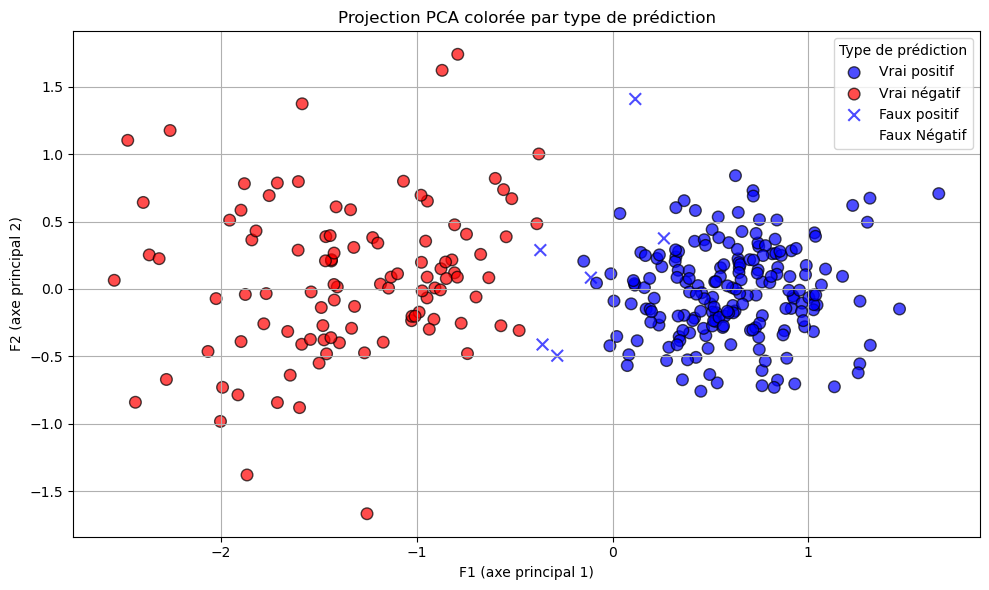

In [56]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Projection PCA sur X_test
pca = PCA(n_components=2)
pca.fit(X_train)  # Apprentissage de la projection sur les données d'entraînement
X_test_proj = pca.transform(X_test)

# 2. Création du DataFrame de visualisation
df_visu = pd.DataFrame(X_test_proj, columns=["F1", "F2"])
df_visu["is_genuine"] = y_test.values
df_visu["Cluster"] = test_clusters
best_pred = pred1 if acc1 > acc2 else pred2
df_visu = df_visu.reset_index(drop=True)  # Alignement des index
df_visu["predicted"] = best_pred

# 3. Étiqueter les cas : VP, VN, FP, FN
def label_case(row):
    if row["is_genuine"] == 1 and row["predicted"] == 1:
        return "Vrai positif"
    elif row["is_genuine"] == 1 and row["predicted"] == 0:
        return "Faux Négatif"
    elif row["is_genuine"] == 0 and row["predicted"] == 1:
        return "Faux positif"
    else:
        return "Vrai négatif"

df_visu["case"] = df_visu.apply(label_case, axis=1)

# 4. Couleur par cluster (pour visuel)
cluster_colors = {0: "red", 1: "blue"}

# 5. Forme par type de prédiction
marker_map = {
    "Vrai positif": "o",
    "Vrai négatif": "o",
    "Faux positif": "x",
    "Faux Négatif": "x"
}

# 6. Tracé de la projection
plt.figure(figsize=(10, 6))

for case in ["Vrai positif", "Vrai négatif", "Faux positif", "Faux Négatif"]:
    subset = df_visu[df_visu["case"] == case]
    plt.scatter(
        subset["F1"], subset["F2"],
        c=subset["Cluster"].map(cluster_colors),
        marker=marker_map[case],
        label=case,
        edgecolor="k",
        s=70,
        alpha=0.7
    )

plt.xlabel("F1 (axe principal 1)")
plt.ylabel("F2 (axe principal 2)")
plt.title("Projection PCA colorée par type de prédiction")
plt.legend(title="Type de prédiction", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


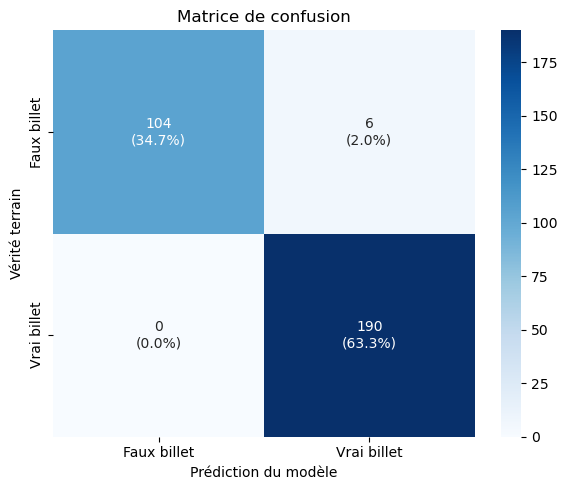

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Utiliser la meilleure prédiction
best_pred = pred1 if acc1 > acc2 else pred2

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, best_pred)

# Calcul des pourcentages
cm_percent = cm.astype('float') / cm.sum() * 100

# Création des labels avec valeur brute + %
labels = np.array([
    [f"{val}\n({pct:.1f}%)" for val, pct in zip(row, pct_row)]
    for row, pct_row in zip(cm, cm_percent)
])

# Affichage heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues',
            xticklabels=['Faux billet', 'Vrai billet'],
            yticklabels=['Faux billet', 'Vrai billet'])
plt.xlabel("Prédiction du modèle")
plt.ylabel("Vérité terrain")
plt.title("Matrice de confusion")
plt.tight_layout()
plt.show()


## 4. KNN (K-Nearest Neighbors)

KNN part du principe que des données similaires ont tendance à se retrouver proches dans l’espace.
classification et regression
Objectif est de determinée les k points de données proche d'un individu en termes de caracteristiques.

### 4.1 Choisir le nombre K de voisins

In [58]:
df_billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [59]:
# Récupération des variables
X = df_billets.drop(columns=['is_genuine'])  
y = df_billets['is_genuine']                 

In [60]:
# Découper en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Liste des valeurs de k à tester
k_values = list(range(1, 30))

In [61]:
# Création de l'instance du classificateur KNN
knn = KNeighborsClassifier()
# Paramètres pour la recherche de grille
param_grid = {'n_neighbors': k_values}

# Recherche de grille avec validation croisée
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Extraction des scores de validation croisée et des valeurs de k correspondantes
cv_scores = grid_search.cv_results_['mean_test_score']
best_k = grid_search.best_params_['n_neighbors']

In [62]:
best_k

7

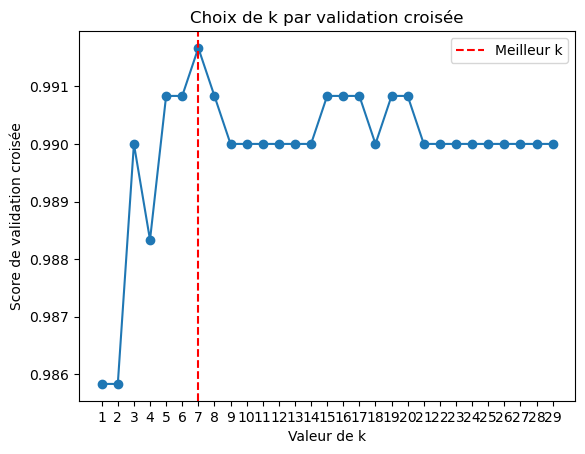

In [63]:
# Tracé du graphique des scores de validation croisée en fonction de k
plt.plot(k_values, cv_scores, '-o')
plt.xlabel('Valeur de k')
plt.ylabel('Score de validation croisée')
plt.title('Choix de k par validation croisée')
plt.xticks(k_values)
plt.axvline(x=best_k, color='r', linestyle='--', label='Meilleur k')
plt.legend()
plt.show()

In [64]:
best_model=grid_search.best_estimator_
# Prédiction sur l'ensemble d'entraînement
y_train_pred = best_model.predict(X_train)
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]

# Prédiction sur l'ensemble de test
y_test_pred = best_model.predict(X_test)
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calcul de l'exactitude sur les ensembles d'entraînement et de test
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Exactitude sur l'ensemble d'entraînement : {:.2f}%".format(accuracy_train * 100))
print("Exactitude sur l'ensemble de test : {:.2f}%".format(accuracy_test * 100))

Exactitude sur l'ensemble d'entraînement : 99.17%
Exactitude sur l'ensemble de test : 98.67%


In [65]:
y_pred = best_model.predict(X)
# Créer une nouvelle colonne dans df_billets
df_billets["pred"] = y_pred

# Créer l'étiquette personnalisée pour la légende
def etiquetter(row):
    if row['is_genuine'] == 1 and row['pred'] == 1:
        return "a1"  # Vrai (Vrai)
    elif row['is_genuine'] == 0 and row['pred'] == 0:
        return "b0"  # Faux (Faux)
    elif row['is_genuine'] == 1 and row['pred'] == 0:
        return "b1"  # Vrai (Faux)
    else:
        return "a0"  # Faux (Vrai)

df_billets["cluster_genuine"] = df_billets.apply(etiquetter, axis=1)



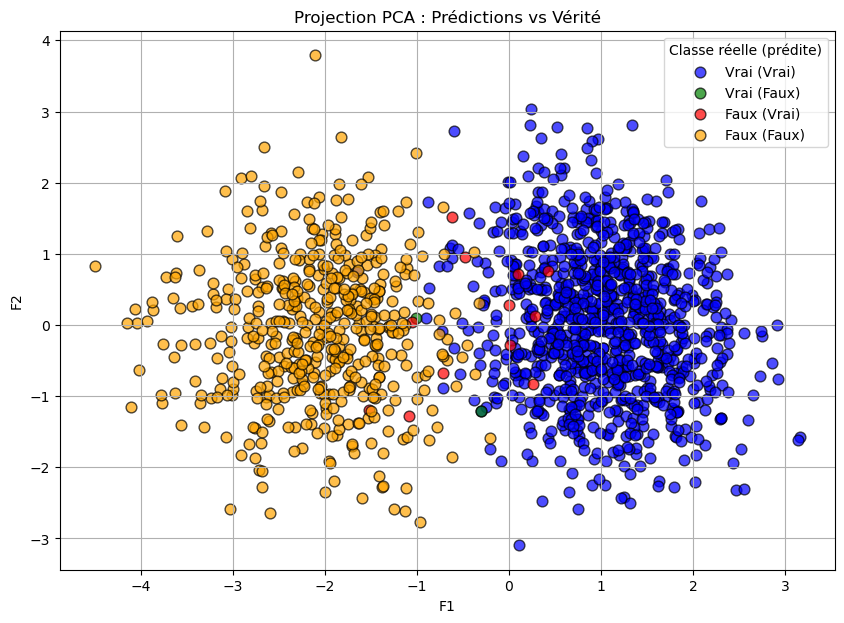

In [66]:
import matplotlib.pyplot as plt

# Mapping noms + couleurs
libelles_legende = {
    'a0': 'Faux (Vrai)',     # FP
    'b0': 'Faux (Faux)',     # TN
    'a1': 'Vrai (Vrai)',     # TP
    'b1': 'Vrai (Faux)'      # FN
}

couleurs_perso = {
    'a1': 'blue',
    'b1': 'green',
    'a0': 'red',
    'b0': 'orange'
}

plt.figure(figsize=(10, 7))

# Tracer chaque groupe
for etiquette, couleur in couleurs_perso.items():
    masque = df_billets["cluster_genuine"] == etiquette
    plt.scatter(
        X_proj[masque, 0],
        X_proj[masque, 1],
        label=libelles_legende[etiquette],
        color=couleur,
        s=60,
        alpha=0.7,
        edgecolors='k'
    )

plt.xlabel("F1")
plt.ylabel("F2")
plt.title("Projection PCA : Prédictions vs Vérité")
plt.legend(title="Classe réelle (prédite)")
plt.grid(True)
plt.show()


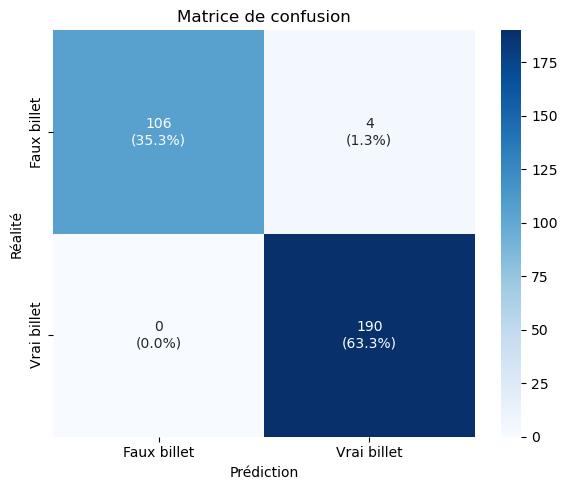

In [67]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)

# Calcul des pourcentages
cm_percent = cm.astype('float') / cm.sum() * 100

# Création des labels (valeurs + pourcentages)
labels = np.array([
    [f"{val}\n({pct:.1f}%)" for val, pct in zip(row, pct_row)]
    for row, pct_row in zip(cm, cm_percent)
])

# Tracé de la heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues',
            xticklabels=['Faux billet', 'Vrai billet'],
            yticklabels=['Faux billet', 'Vrai billet'])
plt.xlabel("Prédiction")
plt.ylabel("Réalité")
plt.title("Matrice de confusion")
plt.tight_layout()
plt.show()


C:\Users\damie\AppData\Local\Temp\ipykernel_16660\450147831.py:47: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


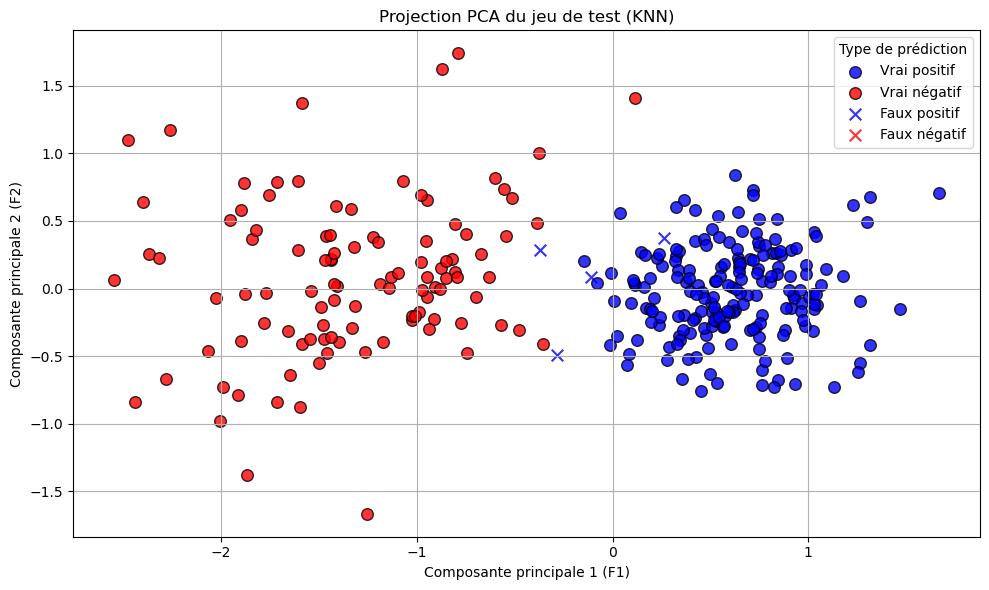

In [68]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# 1. PCA : entraîner sur X_train, projeter X_test
pca = PCA(n_components=2)
pca.fit(X_train)
X_test_proj = pca.transform(X_test)

# 2. Créer un DataFrame de visualisation
df_visu = pd.DataFrame(X_test_proj, columns=["F1", "F2"])
df_visu["is_genuine"] = y_test.values
df_visu["predicted"] = y_test_pred

# 3. Identifier les cas VP, VN, FP, FN
def label_case(row):
    if row["is_genuine"] == 1 and row["predicted"] == 1:
        return "Vrai positif"
    elif row["is_genuine"] == 0 and row["predicted"] == 0:
        return "Vrai négatif"
    elif row["is_genuine"] == 0 and row["predicted"] == 1:
        return "Faux positif"
    else:
        return "Faux négatif"

df_visu["case"] = df_visu.apply(label_case, axis=1)

# 4. Dictionnaires pour formes et couleurs
marker_map = {
    "Vrai positif": "o",
    "Vrai négatif": "o",
    "Faux positif": "x",
    "Faux négatif": "x"
}

color_map = {
    "Vrai positif": "blue",
    "Vrai négatif": "red",
    "Faux positif": "blue",
    "Faux négatif": "red"
}

# 5. Affichage
plt.figure(figsize=(10, 6))
for case in ["Vrai positif", "Vrai négatif", "Faux positif", "Faux négatif"]:
    subset = df_visu[df_visu["case"] == case]
    plt.scatter(
        subset["F1"],
        subset["F2"],
        c=color_map[case],
        marker=marker_map[case],
        label=case,
        edgecolor="k",
        s=70,
        alpha=0.8
    )

plt.xlabel("Composante principale 1 (F1)")
plt.ylabel("Composante principale 2 (F2)")
plt.title("Projection PCA du jeu de test (KNN)")
plt.legend(title="Type de prédiction")
plt.grid(True)
plt.tight_layout()
plt.show()



## 5. Regression logistique

In [69]:
df_billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,pred,cluster_genuine
0,True,171.81,104.86,104.95,4.52,2.89,112.83,True,a1
1,True,171.46,103.36,103.66,3.77,2.99,113.09,True,a1
2,True,172.69,104.48,103.50,4.40,2.94,113.16,True,a1
3,True,171.36,103.91,103.94,3.62,3.01,113.51,True,a1
4,True,171.73,104.28,103.46,4.04,3.48,112.54,True,a1


La régression logistique apprend une fonction qui, pour chaque variable, retourne une probabilité d’être un vrai billet.

In [70]:
# Récupération des variables
X = df_billets.drop(columns=['is_genuine','pred','cluster_genuine'])  
y = df_billets['is_genuine']

In [71]:
# Ajouter une constante pour l'interception
X = sm.add_constant(X)

In [72]:
# Diviser les données en ensembles d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
# Créer le modèle de régression logistique
logit_model = sm.Logit(y_train, X_train)

In [74]:
# Ajuster le modèle aux données d'apprentissage
result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.028446
         Iterations 13


In [75]:
# Afficher le résumé des résultats de la régression
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1193
Method:                           MLE   Df Model:                            6
Date:                Sat, 28 Jun 2025   Pseudo R-squ.:                  0.9549
Time:                        08:40:23   Log-Likelihood:                -34.136
converged:                       True   LL-Null:                       -756.70
Covariance Type:            nonrobust   LLR p-value:                4.106e-309
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -94.0499    263.722     -0.357      0.721    -610.935     422.835
diagonal        -0.2897      1.203     -0.241      0.810      -2.648       2.069
height_left     -1.4026      1.293     -1.08

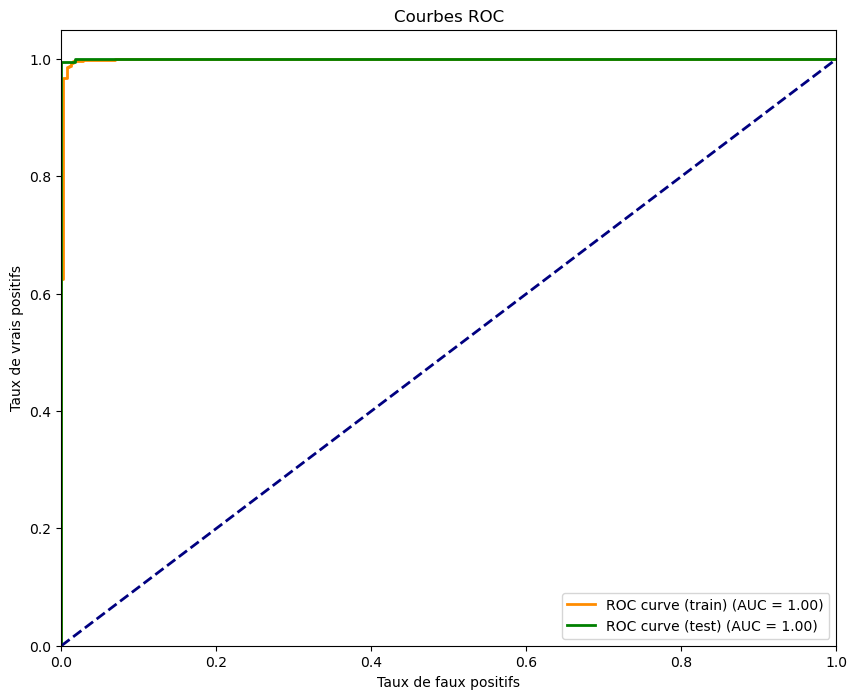

In [76]:
# Obtenir les prédictions du modèle sur l'ensemble d'entraînement et de test
y_train_pred = result.predict(X_train)
y_test_pred = result.predict(X_test)

# Calculer les courbes ROC et les aires sous la courbe (AUC)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)

# Tracer les courbes ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (train) (AUC = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='ROC curve (test) (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC')
plt.legend(loc="lower right")
plt.show()

In [77]:
# Prédire les classes sur la base de test
y_pred = result.predict(X_test) > 0.5

# Générer le rapport de classification
report = classification_report(y_test, y_pred)

# Afficher le rapport de classification
print(report)

              precision    recall  f1-score   support

       False       0.99      0.98      0.99       110
        True       0.99      0.99      0.99       190

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [78]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[108   2]
 [  1 189]]


In [79]:
# Prédire les classes sur la base de test
y_pred = result.predict(X_train) > 0.5

# Générer le rapport de classification
report = classification_report(y_train, y_pred)

# Afficher le rapport de classification
print(report)

              precision    recall  f1-score   support

       False       0.99      0.98      0.99       390
        True       0.99      1.00      0.99       810

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



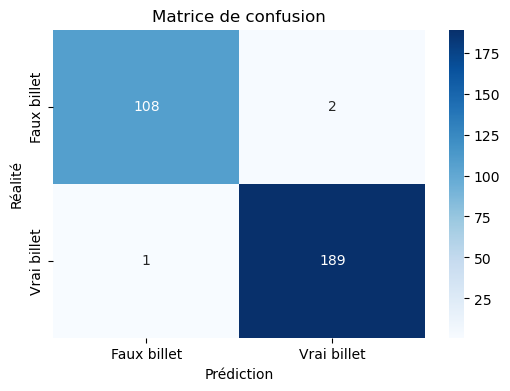

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Prédiction sur l'ensemble de test
y_pred_test = result.predict(X_test) > 0.5

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_test)

# Affichage de la heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Faux billet', 'Vrai billet'], yticklabels=['Faux billet', 'Vrai billet'])
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title("Matrice de confusion")
plt.show()


C:\Users\damie\AppData\Local\Temp\ipykernel_16660\3504114741.py:55: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


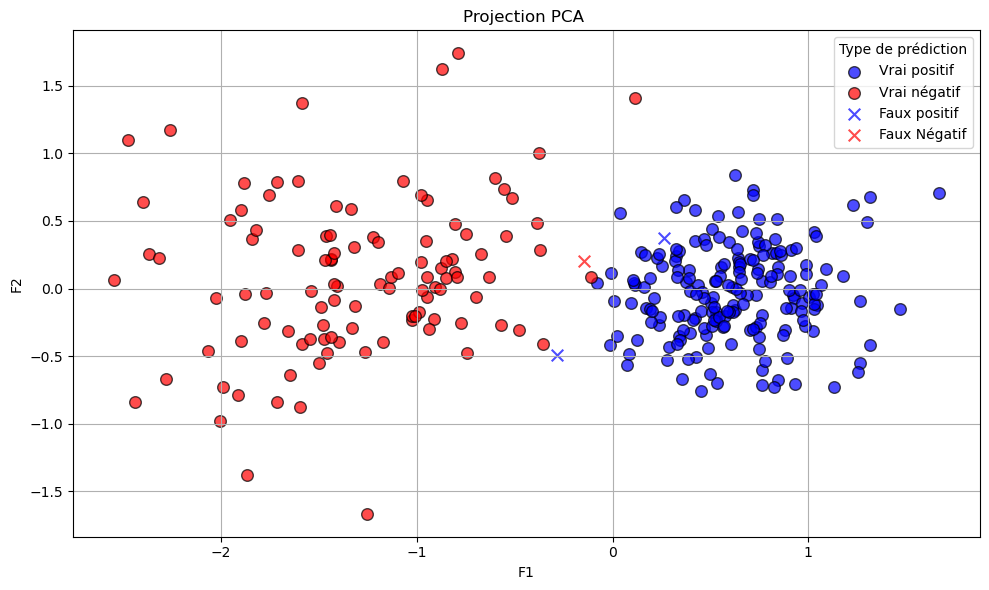

In [81]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# 1. PCA sur X_test
pca = PCA(n_components=2)
pca.fit(X_train)
X_test_proj = pca.transform(X_test)

# 2. DataFrame de visualisation
df_visu = pd.DataFrame(X_test_proj, columns=["F1", "F2"])
df_visu["is_genuine"] = y_test.values
df_visu = df_visu.reset_index(drop=True)

# 3. Prédiction du modèle logistique
y_pred = result.predict(X_test) > 0.5
df_visu["predicted"] = y_pred.values

# 4. Étiquetage VP / VN / FP / FN
def label_case(row):
    if row["is_genuine"] == 1 and row["predicted"] == 1:
        return "Vrai positif"
    elif row["is_genuine"] == 0 and row["predicted"] == 0:
        return "Vrai négatif"
    elif row["is_genuine"] == 0 and row["predicted"] == 1:
        return "Faux positif"
    else:
        return "Faux Négatif"

df_visu["case"] = df_visu.apply(label_case, axis=1)

# 5. Couleurs
color_map = {
    "Vrai positif": "blue",
    "Vrai négatif": "red",
    "Faux positif": "blue",
    "Faux Négatif": "red"
}

# 6. Formes
marker_map = {
    "Vrai positif": "o",
    "Vrai négatif": "o",
    "Faux positif": "x",
    "Faux Négatif": "x"
}

# 7. Tracé final
plt.figure(figsize=(10, 6))

for case in ["Vrai positif", "Vrai négatif", "Faux positif", "Faux Négatif"]:
    subset = df_visu[df_visu["case"] == case]
    plt.scatter(
        subset["F1"], subset["F2"],
        c=color_map[case],
        marker=marker_map[case],
        label=case,
        edgecolor="k",
        s=70,
        alpha=0.7
    )

plt.xlabel("F1")
plt.ylabel("F2")
plt.title("Projection PCA ")
plt.legend(title="Type de prédiction", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


## 6. Decision Tree

In [82]:
df_billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,pred,cluster_genuine
0,True,171.81,104.86,104.95,4.52,2.89,112.83,True,a1
1,True,171.46,103.36,103.66,3.77,2.99,113.09,True,a1
2,True,172.69,104.48,103.50,4.40,2.94,113.16,True,a1
3,True,171.36,103.91,103.94,3.62,3.01,113.51,True,a1
4,True,171.73,104.28,103.46,4.04,3.48,112.54,True,a1


In [83]:
# Récupération des variables
X = df_billets.drop(columns=['is_genuine','cluster_genuine','pred'])  
y = df_billets['is_genuine']

In [84]:
# Division des données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
# Construction de l'arbre de décision
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

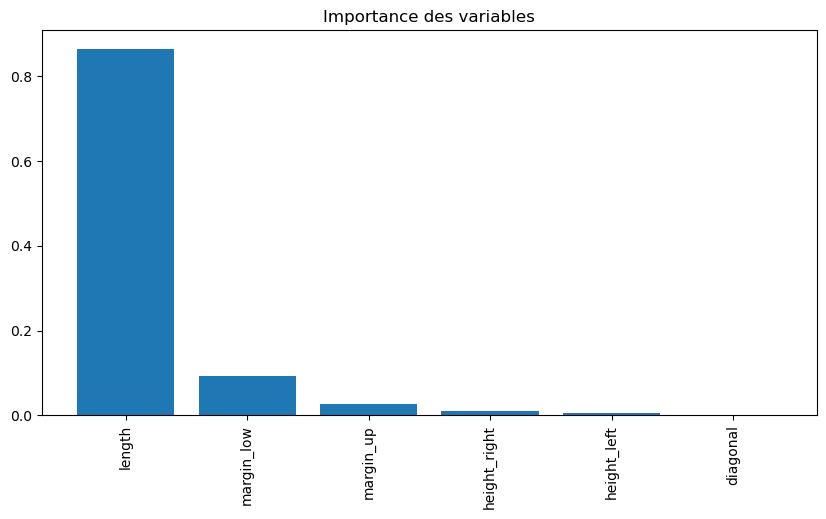

In [86]:
# Affichage de l'importance des variables
importances = tree.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,5))
plt.title("Importance des variables")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=90)
plt.show()

In [87]:
# Prédictions sur l'ensemble d'entraînement
y_train_pred = tree.predict(X_train)

# Évaluation des performances sur l'ensemble d'entraînement
train_accuracy = accuracy_score(y_train, y_train_pred)
train_confusion = confusion_matrix(y_train, y_train_pred)
train_classification = classification_report(y_train, y_train_pred)

print('Performance sur la base apprentissage')
print('Train Accuracy : ', train_accuracy)
print('Train Confusion matrix : \n', train_confusion)
print('Train Classification report : \n', train_classification)

# Prédictions sur l'ensemble de test
y_test_pred = tree.predict(X_test)

# Évaluation des performances sur l'ensemble de test
print('Performance sur la base test')
test_accuracy = accuracy_score(y_test, y_test_pred)
test_confusion = confusion_matrix(y_test, y_test_pred)
test_classification = classification_report(y_test, y_test_pred)

print('Test Accuracy : ', test_accuracy)
print('Test Confusion matrix : \n', test_confusion)
print('Test Classification report : \n', test_classification)

Performance sur la base apprentissage
Train Accuracy :  1.0
Train Confusion matrix : 
 [[390   0]
 [  0 810]]
Train Classification report : 
               precision    recall  f1-score   support

       False       1.00      1.00      1.00       390
        True       1.00      1.00      1.00       810

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200

Performance sur la base test
Test Accuracy :  0.9866666666666667
Test Confusion matrix : 
 [[107   3]
 [  1 189]]
Test Classification report : 
               precision    recall  f1-score   support

       False       0.99      0.97      0.98       110
        True       0.98      0.99      0.99       190

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.99       300
weighted avg       0.99      0.99      0.99       300



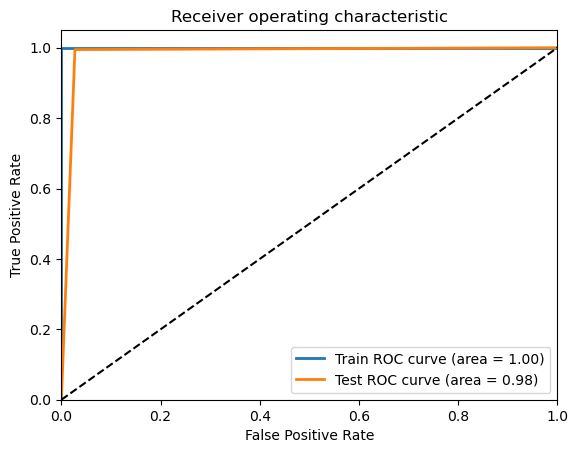

In [88]:
# Prédictions sur l'ensemble d'entraînement
y_train_pred = tree.predict(X_train)
y_train_prob = tree.predict_proba(X_train)[:, 1]

# Prédictions sur l'ensemble de test
y_test_pred = tree.predict(X_test)
y_test_prob = tree.predict_proba(X_test)[:, 1]


# Courbe ROC pour la base train
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_prob)
roc_auc_train = roc_auc_score(y_train, y_train_prob)

# Courbe ROC pour la base test
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob)
roc_auc_test = roc_auc_score(y_test, y_test_prob)

plt.figure()
plt.plot(fpr_train, tpr_train, label='Train ROC curve (area = %0.2f)' % roc_auc_train, linewidth=2)
plt.plot(fpr_test, tpr_test, label='Test ROC curve (area = %0.2f)' % roc_auc_test, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

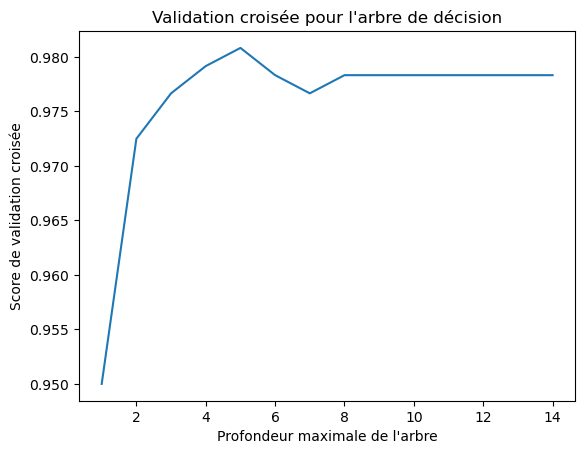

In [89]:
# Liste des profondeurs maximales à tester
max_depths = range(1, 15)

# Liste pour stocker les scores de validation croisée
cv_scores = []

# Pour chaque profondeur maximale, entraîner un arbre de décision et calculer le score de validation croisée
for depth in max_depths:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = cross_val_score(tree, X_train, y_train, cv=10)
    cv_scores.append(np.mean(scores))

# Tracer le graphique de validation croisée pour choisir la complexité de l'arbre optimal
plt.plot(max_depths, cv_scores)
plt.xlabel('Profondeur maximale de l\'arbre')
plt.ylabel('Score de validation croisée')
plt.title('Validation croisée pour l\'arbre de décision')
plt.show()

In [90]:
# Trouver la profondeur maximale qui donne le meilleur score de validation croisée
best_depth = max_depths[np.argmax(cv_scores)]
print('La meilleure profondeur maximale est :', best_depth)

La meilleure profondeur maximale est : 5


In [91]:
# Construire l'arbre de décision avec la profondeur maximale choisie
tree = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

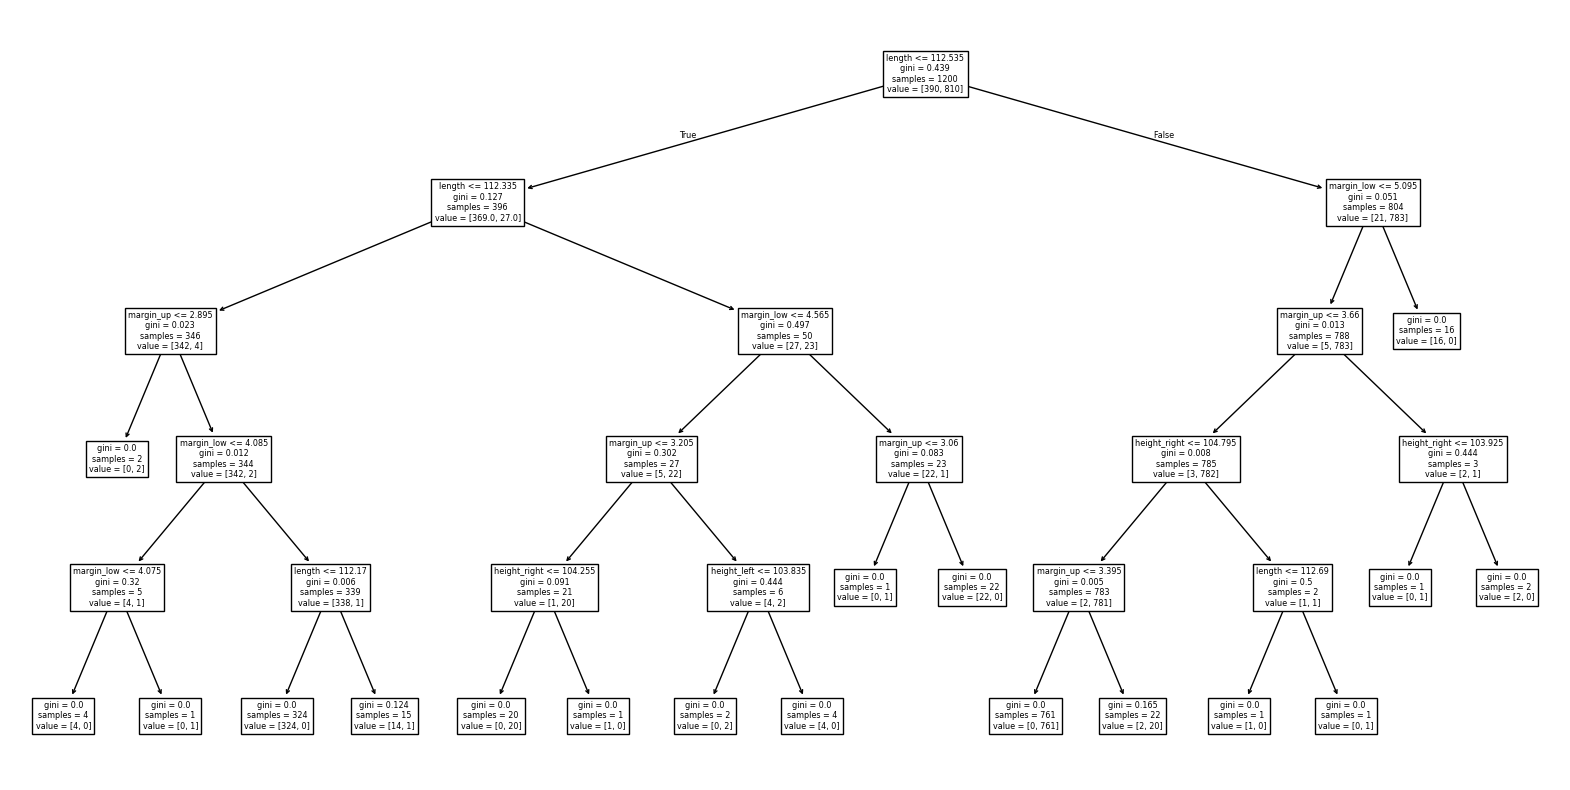

In [92]:
plt.figure(figsize=(20,10))
plot_tree(tree, feature_names=X.columns)
plt.show()

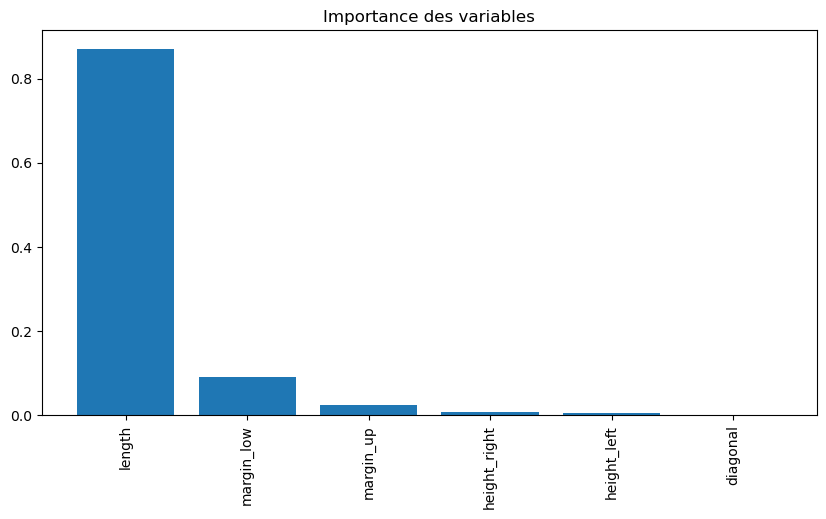

In [93]:
# Affichage de l'importance des variables
importances = tree.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,5))
plt.title("Importance des variables")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=90)
plt.show()

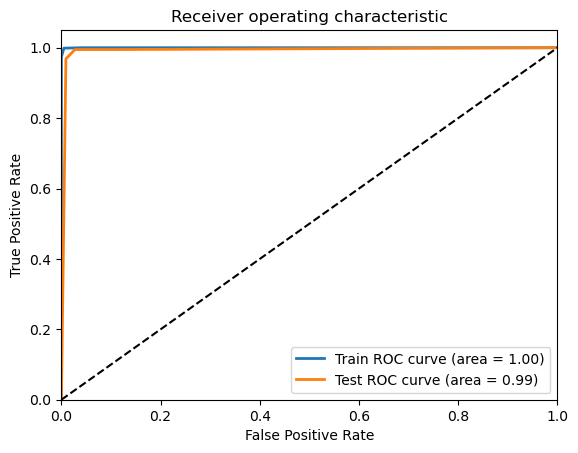

In [94]:
# Prédictions sur l'ensemble d'entraînement
y_train_pred = tree.predict(X_train)
y_train_prob = tree.predict_proba(X_train)[:, 1]

# Prédictions sur l'ensemble de test
y_test_pred = tree.predict(X_test)
y_test_prob = tree.predict_proba(X_test)[:, 1]


# Courbe ROC pour la base train
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_prob)
roc_auc_train = roc_auc_score(y_train, y_train_prob)

# Courbe ROC pour la base test
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob)
roc_auc_test = roc_auc_score(y_test, y_test_prob)

plt.figure()
plt.plot(fpr_train, tpr_train, label='Train ROC curve (area = %0.2f)' % roc_auc_train, linewidth=2)
plt.plot(fpr_test, tpr_test, label='Test ROC curve (area = %0.2f)' % roc_auc_test, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## 7. Random Forest

In [95]:
df_billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,pred,cluster_genuine
0,True,171.81,104.86,104.95,4.52,2.89,112.83,True,a1
1,True,171.46,103.36,103.66,3.77,2.99,113.09,True,a1
2,True,172.69,104.48,103.50,4.40,2.94,113.16,True,a1
3,True,171.36,103.91,103.94,3.62,3.01,113.51,True,a1
4,True,171.73,104.28,103.46,4.04,3.48,112.54,True,a1


In [96]:
#  Créer le modèle Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [97]:
# Récupération des variables
X = df_billets.drop(columns=['is_genuine','cluster_genuine','pred'])  
y = df_billets['is_genuine']

In [98]:
# Division des données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [99]:
# 2. Entraîner sur les mêmes données 
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [100]:
# Sauvegarde du modèle
joblib.dump(rf_model, 'random_forest_billets.pkl')

['random_forest_billets.pkl']

In [101]:
# Prédiction sur X_test
rf_pred = rf_model.predict(X_test)

In [102]:
# Évaluation
acc_rf = accuracy_score(y_test, rf_pred)
print(" Accuracy Random Forest :", acc_rf)

 Accuracy Random Forest : 0.99


In [103]:
# Matrice de confusion
print("\n Matrice de confusion :")
print(confusion_matrix(y_test, rf_pred))


 Matrice de confusion :
[[107   3]
 [  0 190]]


In [104]:
# Rapport complet : précision, rappel, f1-score
print("Rapport de classification :")
print(classification_report(y_test, rf_pred))

Rapport de classification :
              precision    recall  f1-score   support

       False       1.00      0.97      0.99       110
        True       0.98      1.00      0.99       190

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



C:\Users\damie\AppData\Local\Temp\ipykernel_16660\2573228497.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Variable", data=feat_imp, palette="viridis")
C:\Users\damie\AppData\Local\Temp\ipykernel_16660\2573228497.py:16: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\anaconda\envs\Openclass\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


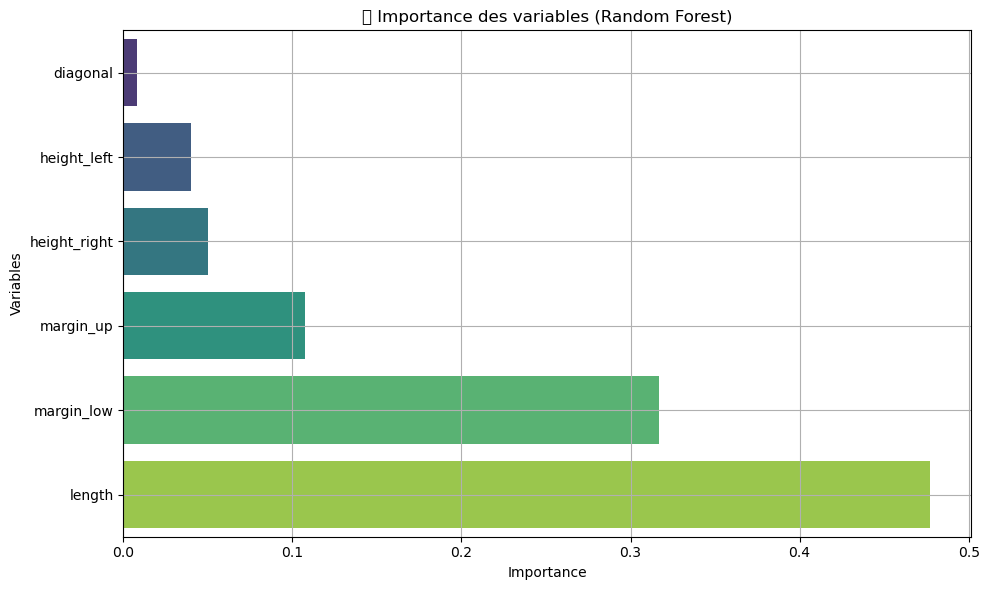

In [105]:
# Extraire l'importance des variables
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Mettre sous forme de DataFrame pour trier et afficher
feat_imp = pd.DataFrame({"Variable": feature_names, "Importance": importances})
feat_imp = feat_imp.sort_values(by="Importance", ascending=True)

# Tracer
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Variable", data=feat_imp, palette="viridis")
plt.title("🎯 Importance des variables (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\damie\AppData\Local\Temp\ipykernel_16660\3799731404.py:45: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


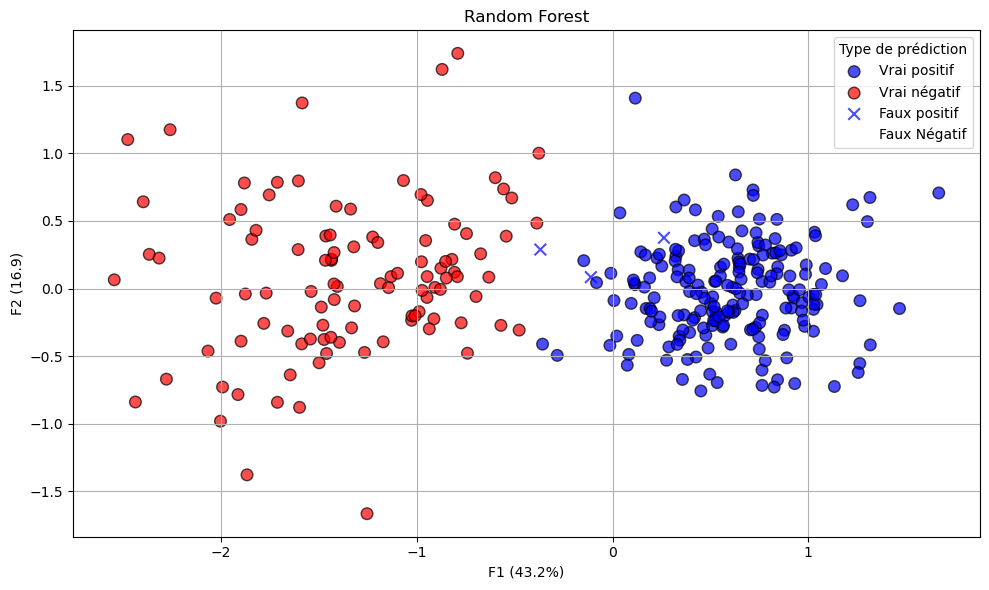

In [109]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# 1. Projection PCA sur X_test (apprentissage sur X_train)
pca = PCA(n_components=2)
pca.fit(X_train)
X_test_proj = pca.transform(X_test)

# 2. Création du DataFrame de visualisation
df_rf_visu = pd.DataFrame(X_test_proj, columns=["F1", "F2"])
df_rf_visu["is_genuine"] = y_test.reset_index(drop=True)
df_rf_visu["Cluster"] = test_clusters  # Assure-toi que test_clusters est bien aligné
df_rf_visu["predicted"] = rf_model.predict(X_test)

# 3. Étiquetage des cas
def label_case(row):
    if row["is_genuine"] == 1 and row["predicted"] == 1:
        return "Vrai positif"
    elif row["is_genuine"] == 1 and row["predicted"] == 0:
        return "Faux Négatif"
    elif row["is_genuine"] == 0 and row["predicted"] == 1:
        return "Faux positif"
    else:
        return "Vrai négatif"

df_rf_visu["case"] = df_rf_visu.apply(label_case, axis=1)

# 4. Couleur par cluster
cluster_colors = {0: "red", 1: "blue"}

# 5. Forme par type de prédiction
marker_map = {
    "Vrai positif": "o",
    "Vrai négatif": "o",
    "Faux positif": "x",
    "Faux Négatif": "x"
}

# 6. Tracé de la projection PCA
plt.figure(figsize=(10, 6))

for case in ["Vrai positif", "Vrai négatif", "Faux positif", "Faux Négatif"]:
    subset = df_rf_visu[df_rf_visu["case"] == case]
    plt.scatter(
        subset["F1"], subset["F2"],
        c=subset["Cluster"].map(cluster_colors),
        marker=marker_map[case],
        label=case,
        edgecolor="k",
        s=70,
        alpha=0.7
    )

plt.xlabel("F1 (43.2%)")
plt.ylabel("F2 (16.9)")
plt.title("Random Forest")
plt.legend(title="Type de prédiction", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, rf_pred)

# Création de la heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Faux", "Vrai"], 
            yticklabels=["Faux", "Vrai"])
plt.xlabel("Prédiction")
plt.ylabel("Réalité")
plt.title("Matrice de confusion")
plt.show()
